# Анализ и план действий по удержанию клиентов для сети фитнес-центров "Культурист-датасаентист"

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Индикаторы оттока зависят от специфики отрасли. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.  
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

**Задачи проекта**:

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента,
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства,
* проанализировать основные признаки, наиболее сильно влияющие на отток,
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов,
    2. предложить меры по снижению оттока,
    3. определить другие особенности взаимодействия с клиентами.
    
**Цель исследования** - провести анализ и подготовить план действий по удержанию клиентов.

## План работы

* Предобработка данных
* Исследовательский анализ данных (EDA)
* Построение модели прогнозирования оттока клиентов
* Создание кластеризации клиентов
* Общий вывод

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import math as mth

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

## Предобработка данных

In [2]:
# чтение файла с данными

gym = pd.read_csv('gym_churn.csv')
   
pd.set_option('display.max_colwidth', None)

gym.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [3]:
# приводим названия столбцов к нижнему регистру
gym.columns = gym.columns.str.lower()

In [4]:
gym.info() # получение общей информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [5]:
gym.isna().sum() # проверка пропущенных значений

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [6]:
gym.duplicated().sum() # проверка дубликатов

0

In [7]:
gym['month_to_end_contract'].value_counts() # проверка значений столбца

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

In [8]:
pd.options.display.float_format = '{:,.2f}'.format # округляем дробные числовые значения до сотых
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype(np.int64)  # переводим данные в целочисленный тип

Мы обладаем данными 4000 клиентов. В данных нет пропусков, нет строк-дубликатов, т.е. мы обладаем полным набором данных. Привели названия столбцов к нижнему регистру, значения в столбце 'month_to_end_contract' к целочисленному типу для удобства при дальнейшей работе.

## Исследовательский анализ данных (EDA)

In [9]:
# определяем отсутствующие признаки, изучаем средние значения и стандартные отклонения 

gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


**Вывод**:

* Распределение по половому признаку примерно одинаково
* Большинство клиентов (85%) живут/работают рядом с фитнес-центром
* Половина клиентов пришли по партнерской программе
* 31% клиентов пришли по программе "Приведи друга"
* Почти у всех (90%) в данных присутствует номер телефона
* Средний контрактный период - 5 месяцев, хотя в целом есть абонементы от 1 до 12 месяцев
* Групповые занятия посещают примерно половина клиентов
* Средний возраст клиентов 29-30 лет, при этом самые молодые - 18 лет, а самые старшие - 41 год, т.е. либо в клубе нет детских программ и не предусмотрено посещение людьми пенсионного возраста (нет скидки на абонемент для них, например), либо выборка взята только из совершеннолетних и непенсионеров
* Средние дополнительные расходы - 147 у.е., максимальная сумма дополнительных расходов - 553 у.е.
* Средний срок окончания действия абонементов - 4 месяца, но разброс большой - от 1 до 12 месяцев
* Среднее время с момента первого посещения также примерно 4 месяца, разброс также большой - от 1 месяца до 2.5 лет
* Средняя частота посещений клуба и за все время с начала действия абонемента, и за последний месяц примерно одинаковая - 1-2 раза, но есть и те, посещает клуб каждый день - 6-7 раз в неделю
* Отток пользователей в текущем месяце - 27%

In [10]:
# изучаем средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

gym.groupby(['churn']).mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


**Вывод**:

* Распределение по половому признаку примерно одинаково как среди ушедших, так и среди оставшихся
* Среди оставшихся больше доля тех, кто живет/работает рядом с фитнес-центром (87% среди оставшихся против 77% среди ушедших)
* Среди оставшихся больше доля тех, кто пришел по партнерской программе (53% против 36%)
* Среди оставшихся больше доля тех, кто пришел по программе "Приведи друга" (35% против 18%)
* Номер телефона присутсвует у 90% клиентов в каждой из групп оттока
* Среди оставшихся средний контрактный период длиннее (5-6 месяцев против 1-2 месяцев - возможно, в клубе абонемент на 1-2 месяца - пробный, после чего те, кому клуб не понравился, отсеиваются)
* Групповые занятия посещают примерно половина клиентов среди оставшихся и 27% среди ушедших
* Средний возраст оставшихся клиентов клиентов 29-30 лет, среди ушедших - 27 лет
* Оставшиеся клиенты больше тратят на дополнительные услуги, средние дополнительные расходы у них 158.5 у.е., а у ушедших - 115 у.е.
* Средний срок окончания действия абонементов среди оставшихся - 5-6 месяцев, среди ушедших - 1-2 месяца
* Среднее время с момента первого посещения среди оставшихся 4-5 месяцев, среди ушедших - 1 месяц 
* Средняя частота посещений клуба и за все время с начала действия абонемента, и за последний месяц примерно одинаковая: среди оставшихся около 2 раз в неделю, среди ушедших 1-2 раза в неделю.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


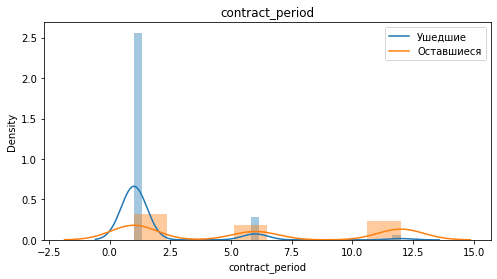

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


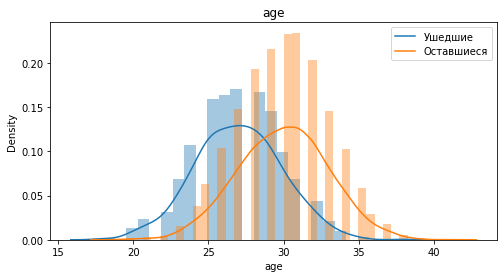

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


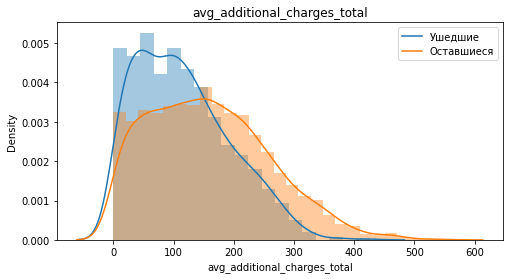

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


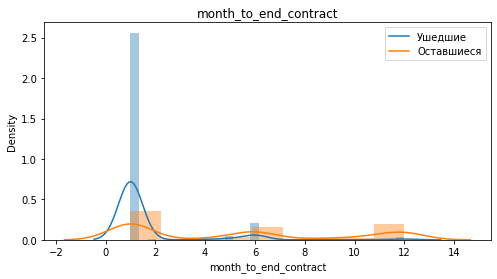

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


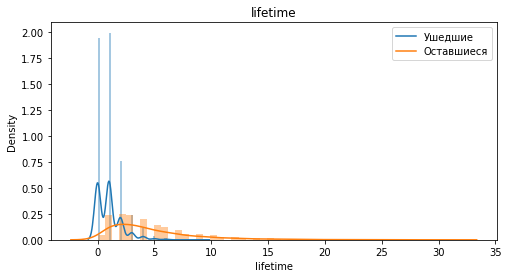

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


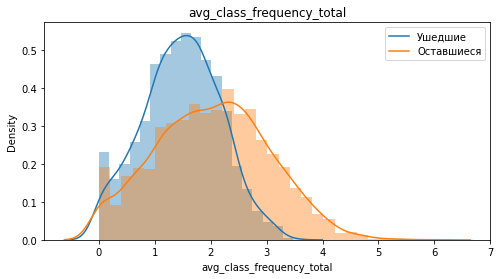

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


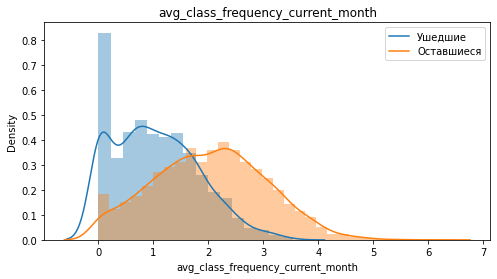

In [11]:
# строим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

left = gym.query('churn == 1')
remaining = gym.query('churn == 0')
columns = [
    'contract_period', 
    'age', 
    'avg_additional_charges_total', 
    'month_to_end_contract', 
    'lifetime', 
    'avg_class_frequency_total', 
    'avg_class_frequency_current_month'] # столбцы с небинарными признаками

for column in columns:
    plt.figure(figsize=(8, 4)) 
    sns.distplot(left[column])
    sns.distplot(remaining[column])
    plt.title(column)
    plt.legend(['Ушедшие', 'Оставшиеся'])
    plt.show()

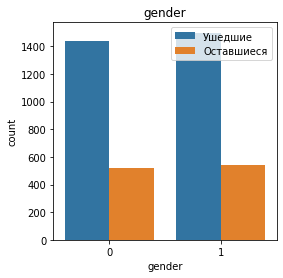

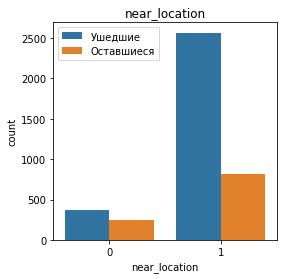

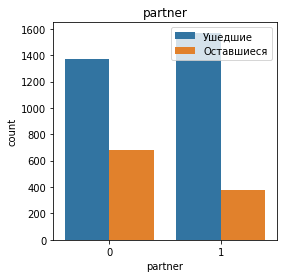

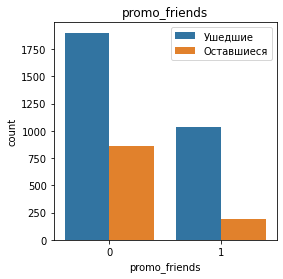

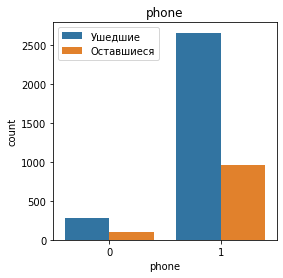

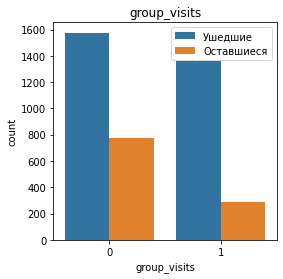

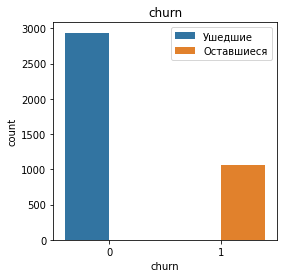

In [12]:
# строим гистограммы для бинарных признаков

for column in gym.columns:
    if column not in columns:
        plt.figure(figsize=(4, 4))
        sns.countplot(x = gym[column], hue='churn', data=gym)
        plt.title(column)
        plt.legend(['Ушедшие', 'Оставшиеся'])
        plt.show()

Графики подтверждают вышеперечисленные выводы, сделанные на основе анализа средних значений признаков по ушедшим и оставшимся. Только в распределении средней частоты посещений клуба за последний месяц среди тех, кто ушел, больше всего клиентов, которые не посещали клуб.

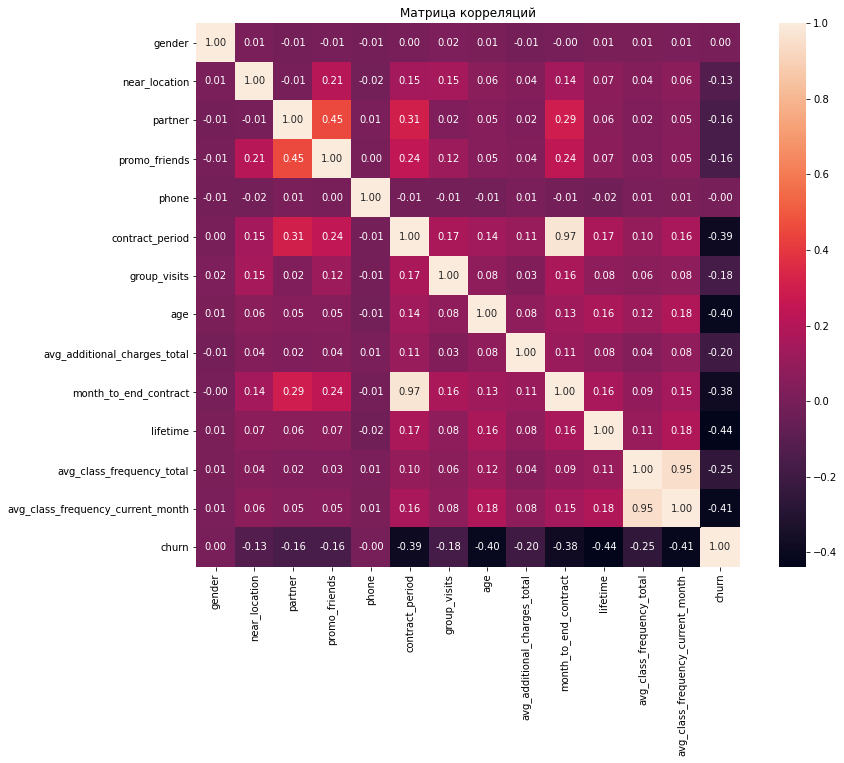

In [13]:
# строим матрицу корреляций для всех клиентов

plt.figure(figsize=(14,10))
sns.heatmap(data = gym.corr(), annot=True, square=True, fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

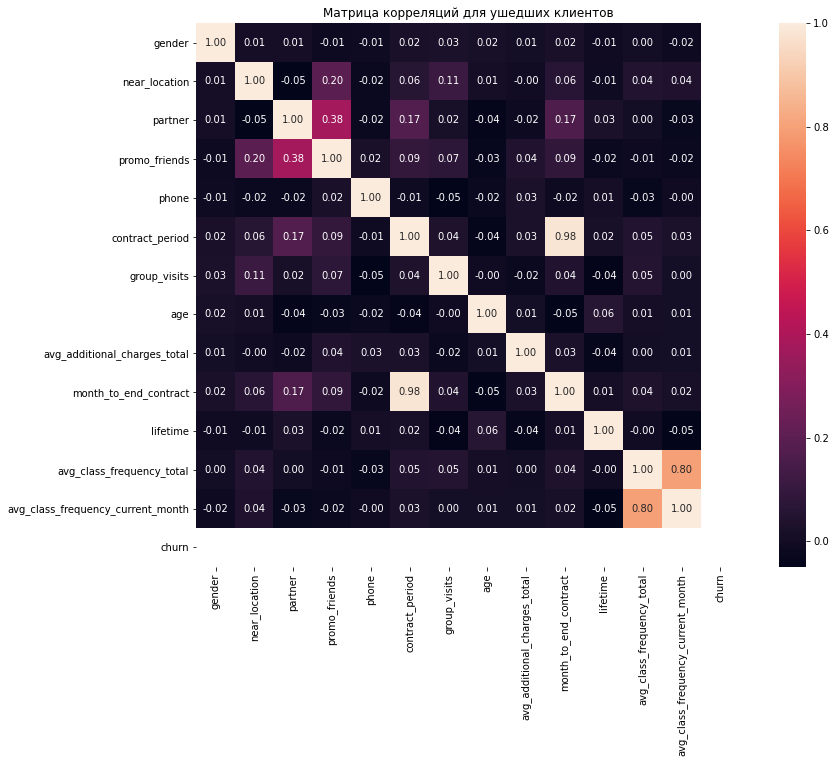

In [14]:
# строим матрицу корреляций для ушедших клиентов

plt.figure(figsize=(14,10))
sns.heatmap(data = left.corr(), annot=True, square=True, fmt='.2f')
plt.title('Матрица корреляций для ушедших клиентов')
plt.show()

В таблицах есть мультиколлинеарные признаки. Это avg_class_frequency_current_month и avg_class_frequency_total, contract_period и month_to_end_contract. Также есть признаки, которые вообще не влияют на отток, это phone и gender.  
Наибольшее, но не настолько большое, чтобы считать его совершенным, влияние на отток оказывают время с момента первого посещения,  частота посещений за последний месяц, возраст, длительность контракта и количество месяцев до его окончания.

**Общий вывод по исследованию**:

Большинство клиентов, которые попали в отток, владели абонементами сроком 1-2 месяца и посещали клуб 1-2 раза в неделю, а за последний месяц большинство из них не посещали клуб совсем. Средний возраст посетителей клуба 29-30, но в отток попадают более молодые клиенты, средний возраст которых 27 лет. Большинство клиентов в оттоке те, кто купил абоненемнт, но ни разу не посетил фитнес-клуб, либо те, кто не посещал последний месяц.  
Видно, что в отток попадают клиенты, которые купили пробный абонемент на 1-2 месяца, редко посещают фитнес-клуб, непосещают групповые программы и которые не получили скидку по партнерской программе или программе "Приведи друга".

## Построение модели прогнозирования оттока клиентов

In [15]:
# создаем матрицу с признаками и целевую переменную (факт оттока в текущем месяце)

x = gym.drop(['churn'], axis=1)
y = gym['churn']

In [17]:
# разбиваем данные на обучающую и валидационную выборку

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [18]:
# обучаем модель на train-выборке с помощью логистической регрессии

model_lr = LogisticRegression(random_state = 0, solver='liblinear')
model_lr.fit(x_train, y_train)
predictions_lr = model_lr.predict(x_test)
probabilities_lr = model_lr.predict_proba(x_test)[:,1]

In [19]:
# оцениваем метрики accuracy, precision и recall для логистической регрессии на валидационной выборке

print('Accuracy_logistic_regression: {:.2f}'.format(accuracy_score(y_test, predictions_lr)))
print('Precision_logistic_regression: {:.2f}'.format(precision_score(y_test, predictions_lr)))
print('Recall_logistic_regression: {:.2f}'.format(recall_score(y_test, predictions_lr)))

Accuracy_logistic_regression: 0.93
Precision_logistic_regression: 0.89
Recall_logistic_regression: 0.84


In [20]:
# обучаем модель на train-выборке с помощью случайного леса

model_rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
model_rf.fit(x_train, y_train)
predictions_rf = model_rf.predict(x_test)
probabilities_rf = model_rf.predict_proba(x_test)[:,1]

In [21]:
# оцениваем метрики accuracy, precision и recall для случайного леса на валидационной выборке

print('Accuracy_random_forest: {:.2f}'.format(accuracy_score(y_test, predictions_rf)))
print('Precision_random_forest: {:.2f}'.format(precision_score(y_test, predictions_rf)))
print('Recall_random_forest: {:.2f}'.format(recall_score(y_test, predictions_rf)))

Accuracy_random_forest: 0.92
Precision_random_forest: 0.88
Recall_random_forest: 0.83


В модели логистической регрессии значения метрик чуть выше, чем в модели случайного леса. Поэтому считаем, что модель логистической регрессии лучше.

## Создание кластеризации клиентов

In [21]:
# стандартизируем данные

scaler = StandardScaler()
x_st = scaler.fit_transform(x)

In [22]:
# строим матрицу расстояний на стандартизованной матрице признаков

linked = linkage(x_st, method='ward')

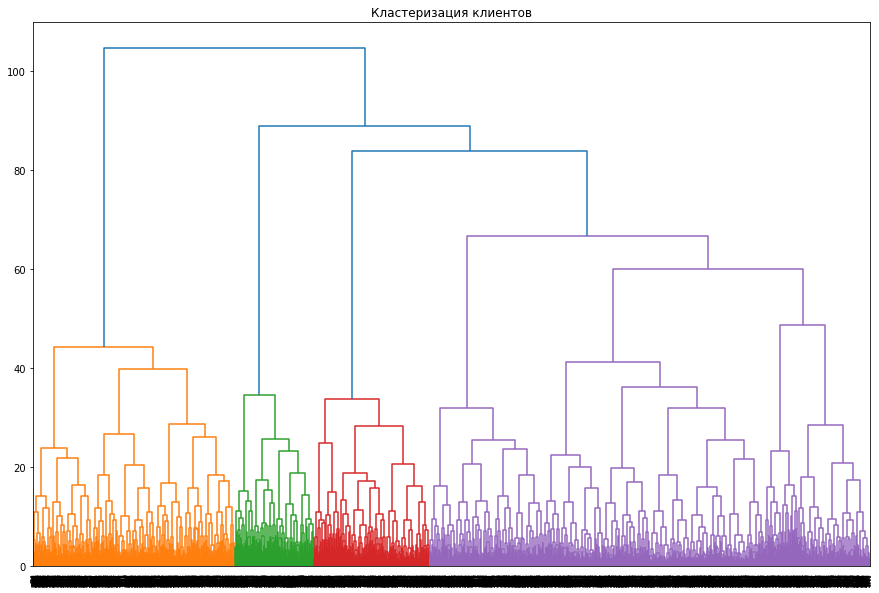

In [23]:
# рисуем дендрограмму

plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show()

На дендрограмме явно выделено 4 кластера.

In [24]:
# обучаем модель кластеризации на основании алгоритма K-Means и прогнозируем кластеры клиентов, число кластеро берем равное 5

km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_st)
gym['cluster'] = labels

In [25]:
# определяем средние значения признаков для кластеров

gym.groupby(['cluster']).mean().T

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


**Кластер 0**:
* Клиенты живут/работают рядом с фитнес-центром
* Многие приобрели абонемент со скидкой (78% по партнерской программе, 57% по программе "Приведи друга")
* Длительный период контракта (до 12 месяцев)
* Наибольший %% тех, кто посещает групповые занятия (54%)
* Самый низкий процент оттока (3%)

**Кластер 1**:
* Клиенты живут/работают рядом с фитнес-центром
* Половина клиентов приобрели абонемент по партнерской программе (47%) и 31% клиентов по программе "Приведи друга"
* Не указан номер телефона
* Средний период контракта (до полугода)
* Отток 27%

**Кластер 2**:
* Клиенты живут/работают далеко от фитнес-центра
* Самый низкий %% клиентов, пришедших по программе "Приведи друга" (8%)
* Самый низкий %% тех, кто посещает групповые занятия (22%)
* Период контракта до 3 месяцев
* Отток 44%

**Кластер 3**:
* Клиенты живут/работают рядом с фитнес-центром
* Самое низкое количество посещений в неделю за последний месяц (1 посещение)
* Самый маленький период контракта (до 2 месяцев)
* Отток 51%

**Кластер 4**:
* Клиенты живут/работают рядом с фитнес-центром
* Высокий %% тех, кто посещает групповые занятия (47%)
* Самое высокое количество посещений в неделю за последний месяц (2-3 посещения)
* Наибольшая сумма дополнительных затрат (162 у.е.)
* Период контракта до 3 месяцев
* Отток 7%

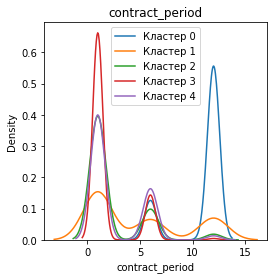

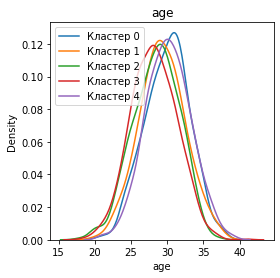

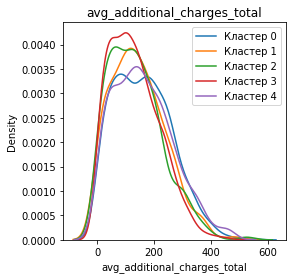

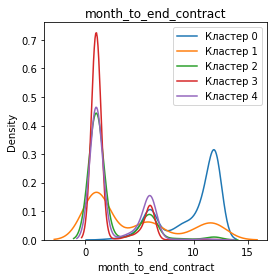

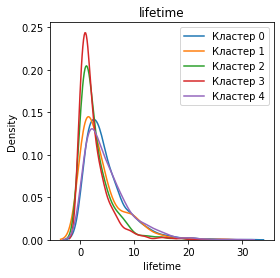

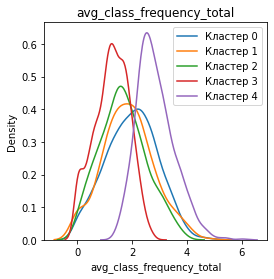

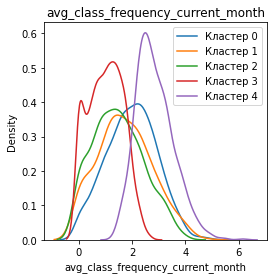

In [26]:
# строим распределения небинарных признаков для кластеров

columns = [
    'contract_period', 
    'age', 
    'avg_additional_charges_total', 
    'month_to_end_contract', 
    'lifetime', 
    'avg_class_frequency_total', 
    'avg_class_frequency_current_month']

for column in columns:
    plt.figure(figsize=(4, 4)) 
    sns.kdeplot(gym.query('cluster==0')[column], label = 'Кластер 0')
    sns.kdeplot(gym.query('cluster==1')[column], label = 'Кластер 1')
    sns.kdeplot(gym.query('cluster==2')[column], label = 'Кластер 2')
    sns.kdeplot(gym.query('cluster==3')[column], label = 'Кластер 3')
    sns.kdeplot(gym.query('cluster==4')[column], label = 'Кластер 4')
    plt.title(column)
    plt.legend()
    plt.show()

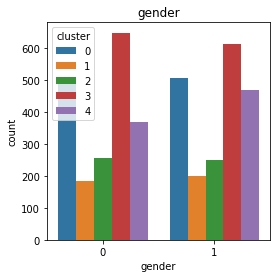

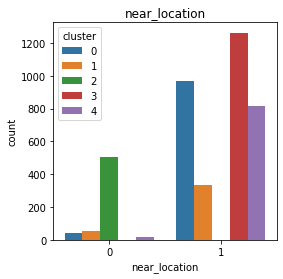

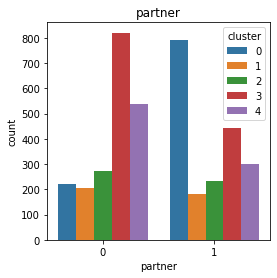

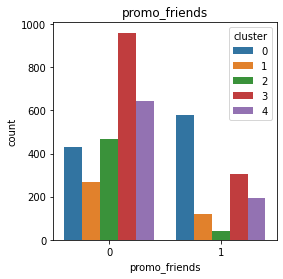

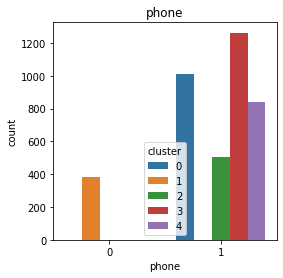

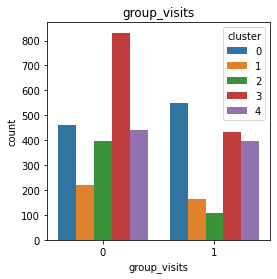

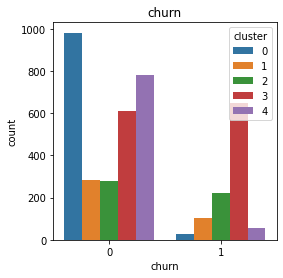

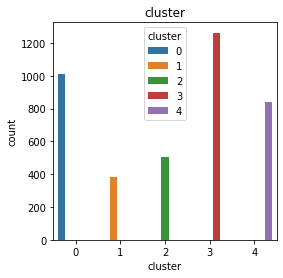

In [27]:
# строим распределения бинарных признаков для кластеров

for column in gym.columns:
    if column not in columns:
        plt.figure(figsize=(4, 4))
        sns.countplot(x = gym[column], hue='cluster', data=gym)
        plt.title(column)
        plt.show()

Графики подтверждают вышеперечисленные выводы, сделанные на основе анализа средних значений признаковпо кластерам.

In [28]:
# считаем долю оттока для каждого полученного кластера

gym.groupby('cluster').agg({'churn':'mean', 'age':'count'}).sort_values(by='churn', ascending=False)

,churn,age
cluster,,
3,0.51,1262
2,0.44,505
1,0.27,385
4,0.07,838
0,0.03,1010


Наиболее надежные кластеры - это кластеры 0 и 4, в них наименьшая доля оттока (3% и 7% соответсвенно). Кластеры, склонные к оттоку - это кластеры 3 и 2, в них наибольшая доля оттока (51% и 44%).

## Общий вывод

### Цель проекта:

* Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов;
    2. предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.


### Входные данные:
Файл с данными клиентов за предыдущий до проверки факта оттока месяц, информацией на основе журнала посещений, покупок и информацией о текущем статусе абонемента клиента.

### Действия по проекту

Была проведена предобработка данных:
 - приведены названия столцов к нижнему регистру,
 - получена общая информация о файле,
 - проверены пропущенные значения и дубликаты,
 - дробные числа округлены до сотых,
 - данные в столбце 'month_to_end_contract' переведены в целочисленный вид.

Был проведен исследовательский анализ данных (EDA):
 - определены отсутствующие признаки, изучены средние значения и стандартные отклонения,
 - определены средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался,
 - построены столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток),
 - построена и отображена матрица корреляций.
 
Была построена модель прогнозирования оттока клиентов:
 - данные разбиты на обучающую и валидационную выборку ,
 - модель модель на train-выборке двумя способами:
     1. логистической регрессией
     2.	случайным лесом
 - метрики accuracy, precision и recall были сравнены для обеих моделей на валидационной выборке.
 
Была сделана кластеризация клиентов:
 - данные были стандартизированы,
 - построена матрица расстояний на стандартизованной матрице признаков,
 - нарисована дендрограмма и выделено количество кластеров,
 - обучена модель кластеризации на основании алгоритма K-Means и спрогнозированы кластеры клиентов,
 - определены средние значения признаков для кластеров,
 - построены распределения признаков для кластеров,
 - посчитана доля оттока для каждого полученного кластера.

### Вывод

У нас есть данные на выборку из 4000 клиентов фитнес-клуба. На основе этих данных можно вывести портрет "идеального клиента". "Идеальный клиент" - это клиент 29-30 лет, живет/работает недалеко от клуба, посещает групповые занятия, посещает фитнес-клуб 2-3 раза в неделю, приобрел абонемент со скидкой либо по партнерской программе, либо по программе "Приведи друга", с длительным сроком абонемента 6-12 месяцев.

Большинство клиентов, которые попали в отток, владели абонементами сроком 1-2 месяца и посещали клуб 1-2 раза в неделю, а за последний месяц большинство из них не посещали клуб совсем. Средний возраст посетителей клуба 29-30, но в отток попадают более молодые клиенты, средний возраст которых 27 лет. Большинство клиентов в оттоке те, кто купил абоненемнт, но ни разу не посетил фитнес-клуб, либо те, кто не посещал последний месяц, а также не посещают групповые программы и которые не получили скидку по партнерской программе или программе "Приведи друга".

Если сравнивать тех, кто ушел, и тех, кто остался, то получится следующая картина:
* Распределение по половому признаку примерно одинаково как среди ушедших, так и среди оставшихся
* Среди оставшихся больше доля тех, кто живет/работает рядом с фитнес-центром (87% среди оставшихся против 77% среди ушедших)
* Среди оставшихся больше доля тех, кто пришел по партнерской программе (53% против 36%)
* Среди оставшихся больше доля тех, кто пришел по программе "Приведи друга" (35% против 18%)
* Номер телефона присутсвует у 90% клиентов в каждой из групп оттока
* Среди оставшихся средний контрактный период длиннее (5-6 месяцев против 1-2 месяцев))
* Групповые занятия посещают примерно половина клиентов среди оставшихся и 27% среди ушедших
* Средний возраст оставшихся клиентов клиентов 29-30 лет, среди ушедших - 27 лет
* Оставшиеся клиенты больше тратят на дополнительные услуги, средние дополнительные расходы у них 158.5 у.е., а у ушедших - 115 у.е.
* Средний срок окончания действия абонементов среди оставшихся - 5-6 месяцев, среди ушедших - 1-2 месяца
* Среднее время с момента первого посещения среди оставшихся 4-5 месяцев, среди ушедших - 1 месяц
* Средняя частота посещений клуба и за все время с начала действия абонемента, и за последний месяц примерно одинаковая: среди оставшихся около 2 раз в неделю, среди ушедших 1-2 раза в неделю.

Все клиенты были разбиты на 5 кластеров.

**Кластер 0**:
* Клиенты живут/работают рядом с фитнес-центром
* Многие приобрели абонемент со скидкой (78% по партнерской программе, 57% по программе "Приведи друга")
* Длительный период контракта (до 12 месяцев)
* Наибольший %% тех, кто посещает групповые занятия (54%)
* Самый низкий процент оттока (3%)

**Кластер 1**:
* Клиенты живут/работают рядом с фитнес-центром
* Половина клиентов приобрели абонемент по партнерской программе (47%) и 31% клиентов по программе "Приведи друга"
* Не указан номер телефона
* Средний период контракта (до полугода)
* Отток 27%

**Кластер 2**:
* Клиенты живут/работают далеко от фитнес-центра
* Самый низкий %% клиентов, пришедших по программе "Приведи друга" (8%)
* Самый низкий %% тех, кто посещает групповые занятия (22%)
* Период контракта до 3 месяцев
* Отток 44%

**Кластер 3**:
* Клиенты живут/работают рядом с фитнес-центром
* Самое низкое количество посещений в неделю за последний месяц (1 посещение)
* Самый маленький период контракта (до 2 месяцев)
* Отток 51%

**Кластер 4**:
* Клиенты живут/работают рядом с фитнес-центром
* Высокий %% тех, кто посещает групповые занятия (47%)
* Самое высокое количество посещений в неделю за последний месяц (2-3 посещения)
* Наибольшая сумма дополнительных затрат (162 у.е.)
* Период контракта до 3 месяцев
* Отток 7%

Таким образом получили информацию, что наименьший отток там, где клиенты живут/работают рядом с фитнес-центром, посещают групповые занятия, посещают клуб 2-3 раза в неделю, приобрели абонемент со скидкой, период контракты свыше 3х месяцев. А в отток попадают те, что живут далеко от клуба, посещают клуб 1-2 раза в неделю, почти не ходят на групповые занятия, период контракта до 3 месяцев. Данные, полученные при разбиении на кластеры, подтвердили выводы, полученные ранее.

### Рекомендации

* Т.к. в отток попадают в большинстве те, кто приобрел абонемент на 1-2 месяца (то есть пробный), то для удержания таких клиентов стоит предложить им скидку на покупку длительного абонемента (6-12 месяцев).
* Можно уменьшить количество видов абонементов и оставить только несколько вариантов (1, 3, 6, 9, 12 месяцев).
* Можно убрать пробные абонементы (1-2 месяца), и вместо них сделать бесплатные 30 дней для друга, которые идут бонусом к абонементу свыше 6 месяцев.
* Добавить бесплатные бонусы к абонементам свыше 6 месяцев (например, 2 пробные бесплатные индивидуальные тренировки в тренажерном зале, бесплатную тренировку на групповые занятия, которые обычно идут за дополнительную плату, посещение салона красоты при клубе, если есть, и т.д.).

Эти рекомендаци помогут в продаже абонементов на более длительный срок, соответственно, отток клиентов будет меньше, т.к. те, у кого длительный абонемент, стараются все же приходить в фитнес-клуб хотя бы 1 раз в неделю.